In [ ]:
import torch

# Clear CUDA cache
torch.cuda.empty_cache()

# Collect unused memory
torch.cuda.ipc_collect()

print("CUDA cache cleared.")


In [ ]:
# upload Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from transformers import ViTForImageClassification, ViTFeatureExtractor
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score
from tqdm import tqdm
from sklearn.metrics import roc_curve, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import time
import kagglehub
import os
import shutil

In [ ]:
# Download dataset
fake_dir = kagglehub.dataset_download("dullaz/1m-ai-generated-faces-128x128")
fake_path = os.path.join(fake_dir, "fake_faces_dataset")  # Path where images are downloaded

print(f"Dataset downloaded to: {fake_path}")


100%|██████████| 4.08G/4.08G [00:36<00:00, 120MB/s]

Extracting files...


Dataset downloaded to: /root/.cache/kagglehub/datasets/dullaz/1m-ai-generated-faces-128x128/versions/5/fake_faces_dataset


In [ ]:
# Download Celeba data real images
real_dir = kagglehub.dataset_download("jessicali9530/celeba-dataset")
real_path = os.path.join(real_dir, "img_align_celeba/img_align_celeba")


100%|██████████| 1.33G/1.33G [00:12<00:00, 119MB/s]

Extracting files...


In [ ]:
# Load real and AI-generated image CSVs
real_csv_path = "/content/drive/MyDrive/w210/final_data/final_celeba_all_balanced.csv"
ai_csv_path = "/content/drive/MyDrive/w210/final_data/final_million_all_balanced.csv"

real_df = pd.read_csv(real_csv_path)
ai_df = pd.read_csv(ai_csv_path)

# Combine both datasets
full_df = pd.concat([real_df, ai_df], ignore_index=True)

# shuffle order of real and AI generated images
full_df = full_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Check the dataset
print(full_df.head())
print(full_df["label"].value_counts())  # Ensure it's balanced


         image_id  gender                                         image_path  \
0      099895.jpg       0  /root/.cache/kagglehub/datasets/jessicali9530/...   
1  JLKU0V4V5W.jpg       1  /root/.cache/kagglehub/datasets/dullaz/1m-ai-g...   
2      053207.jpg       1  /root/.cache/kagglehub/datasets/jessicali9530/...   
3      153736.jpg       0  /root/.cache/kagglehub/datasets/jessicali9530/...   
4  O2MVI85PXZ.jpg       1  /root/.cache/kagglehub/datasets/dullaz/1m-ai-g...   

   age                                             region  ethnicity  label  
0   30  {'x': 37, 'y': 74, 'w': 105, 'h': 105, 'left_e...          1      1  
1   23  {'x': 19, 'y': 27, 'w': 88, 'h': 88, 'left_eye...          0      0  
2   39  {'x': 44, 'y': 82, 'w': 91, 'h': 91, 'left_eye...          1      1  
3   33  {'x': 30, 'y': 73, 'w': 105, 'h': 105, 'left_e...          1      1  
4   40  {'x': 13, 'y': 19, 'w': 102, 'h': 102, 'left_e...          1      0  
label
1    39700
0    39700
Name: count, dtype: int

In [ ]:
# Create output directory if it doesn't exist because we want to make sure there is no data leakage due to file name and file paths.
# to prevent the model from using the file name and file path to deterine if the image is real or AI generated.
output_dir = '/content/drive/MyDrive/w210/final_data/all_images'
os.makedirs(output_dir, exist_ok=True)

# Rename and copy
new_image_paths = []
for idx, row in full_df.iterrows():
    new_filename = f"{idx:05d}.jpg"  # 00000.jpg, 00001.jpg, etc.
    old_path = row['image_path']
    shutil.copy(old_path, os.path.join(output_dir, new_filename))
    new_image_paths.append(new_filename)

# Update dataframe
full_df['image_filename'] = new_image_paths
full_df = full_df.drop(columns=['image_id','image_path'])  # Drop old paths

# Save to CSV
full_df.to_csv('/content/drive/MyDrive/w210/final_data/combined_dataset.csv', index=False)

# Check the result
print(full_df.head())
print(full_df["label"].value_counts())  # Ensure balance

In [ ]:
# Update dataframe
full_df['image_filename'] = new_image_paths
full_df = full_df.drop(columns=['image_id'])  # Drop old paths

# Save to CSV
full_df.to_csv('/content/drive/MyDrive/w210/final_data/combined_dataset.csv', index=False)

# Check the result
print(full_df.head())
print(full_df["label"].value_counts())  # Ensure balance

In [ ]:
#reorder the columns to image_id, image_path, region, gender, ethnicity, age, label
full_df = full_df[["image_filename", "region", "gender", "ethnicity", "age", "label"]]
full_df.head()

,image_filename,region,gender,ethnicity,age,label
0,00000.jpg,"{'x': 37, 'y': 74, 'w': 105, 'h': 105, 'left_e...",0,1,30,1
1,00001.jpg,"{'x': 19, 'y': 27, 'w': 88, 'h': 88, 'left_eye...",1,0,23,0
2,00002.jpg,"{'x': 44, 'y': 82, 'w': 91, 'h': 91, 'left_eye...",1,1,39,1
3,00003.jpg,"{'x': 30, 'y': 73, 'w': 105, 'h': 105, 'left_e...",0,1,33,1
4,00004.jpg,"{'x': 13, 'y': 19, 'w': 102, 'h': 102, 'left_e...",1,1,40,0


In [ ]:
# Compute the mean (average) age
average_age = full_df["age"].mean()
print(f"Average Age: {average_age:.2f}")

Average Age: 31.71


In [ ]:
full_df["age_bin"] = pd.cut(full_df["age"], bins=[0, average_age, float("inf")], labels=["below_mean", "above_mean"])

In [ ]:
full_df.head()

,image_filename,region,gender,ethnicity,age,label,age_bin
0,00000.jpg,"{'x': 37, 'y': 74, 'w': 105, 'h': 105, 'left_e...",0,1,30,1,below_mean
1,00001.jpg,"{'x': 19, 'y': 27, 'w': 88, 'h': 88, 'left_eye...",1,0,23,0,below_mean
2,00002.jpg,"{'x': 44, 'y': 82, 'w': 91, 'h': 91, 'left_eye...",1,1,39,1,above_mean
3,00003.jpg,"{'x': 30, 'y': 73, 'w': 105, 'h': 105, 'left_e...",0,1,33,1,above_mean
4,00004.jpg,"{'x': 13, 'y': 19, 'w': 102, 'h': 102, 'left_e...",1,1,40,0,above_mean


In [ ]:
# Stratify by gender, ethnicity, and age
stratify_cols = full_df[["gender", "ethnicity", "age_bin"]].astype(str)
full_df["stratify_group"] = stratify_cols.apply(lambda x: "_".join(x), axis=1)  # Create stratification column

# Split Train (70%) and Temp (30%)
train_df, temp_df = train_test_split(full_df, test_size=0.3, stratify=full_df["stratify_group"], random_state=42)

# Split Temp into Validation (15%) and Test (15%)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df["stratify_group"], random_state=42)

# Shuffle after splitting
train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)
val_df = val_df.sample(frac=1, random_state=42).reset_index(drop=True)
test_df = test_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Drop the stratify_group column
train_df = train_df.drop(columns=["stratify_group"])
val_df = val_df.drop(columns=["stratify_group"])
test_df = test_df.drop(columns=["stratify_group"])

# Define save directory
save_dir = "/content/drive/MyDrive/w210/final_data"

# Save datasets including demographic columns for later fairness analysis
columns_to_save = ["image_filename", "region", "gender", "ethnicity", "age_bin", "label"]


train_df[columns_to_save].to_csv(f"{save_dir}/train_data.csv", index=False)
val_df[columns_to_save].to_csv(f"{save_dir}/val_data.csv", index=False)
test_df[columns_to_save].to_csv(f"{save_dir}/test_data.csv", index=False)

print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")

Train: 55580, Val: 11910, Test: 11910


In [ ]:
# Define the file paths
save_dir = "/content/drive/MyDrive/w210/final_data/combined_splits"
train_path = f"{save_dir}/combined_train_data.csv"
val_path = f"{save_dir}/combined_val_data.csv"
test_path = f"{save_dir}/combined_test_data.csv"

# Load the datasets
train_df = pd.read_csv(train_path)
val_df = pd.read_csv(val_path)
test_df = pd.read_csv(test_path)

# Function to count occurrences of gender, ethnicity, and age_bin
def count_groups(df, dataset_name):
    print(f"\n Distribution in {dataset_name} dataset:")
    print(" Gender Count:")
    print(df["gender"].value_counts())

    print("\n Ethnicity Count:")
    print(df["ethnicity"].value_counts())

    print("\n Age Bin Count:")
    print(df["age_bin"].value_counts())

    print("\n Label Count:")
    print(df["label"].value_counts())

# Count in each dataset
count_groups(train_df, "Train")
count_groups(val_df, "Validation")
count_groups(test_df, "Test")


 Distribution in Train dataset:
 Gender Count:
gender
1    29179
0    26401
Name: count, dtype: int64

 Ethnicity Count:
ethnicity
1    27791
0    27789
Name: count, dtype: int64

 Age Bin Count:
age_bin
below_mean    31389
above_mean    24191
Name: count, dtype: int64

 Label Count:
label
0    27935
1    27645
Name: count, dtype: int64

 Distribution in Validation dataset:
 Gender Count:
gender
1    6253
0    5657
Name: count, dtype: int64

 Ethnicity Count:
ethnicity
1    5955
0    5955
Name: count, dtype: int64

 Age Bin Count:
age_bin
below_mean    6726
above_mean    5184
Name: count, dtype: int64

 Label Count:
label
1    6059
0    5851
Name: count, dtype: int64

 Distribution in Test dataset:
 Gender Count:
gender
1    6252
0    5658
Name: count, dtype: int64

 Ethnicity Count:
ethnicity
0    5956
1    5954
Name: count, dtype: int64

 Age Bin Count:
age_bin
below_mean    6727
above_mean    5183
Name: count, dtype: int64

 Label Count:
label
1    5996
0    5914
Name: count, dtype

In [ ]:
# Preprocess images
# Define image transformations (resize, normalize)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Custom Dataset Class to load images and labels from CSV
class RealVsAIDataset(Dataset):
    def __init__(self, csv_file, image_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.image_dir = image_dir  # Path to unified images folder
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_filename = self.data.iloc[idx]['image_filename']
        img_path = os.path.join(self.image_dir, img_filename)

        label = self.data.iloc[idx]['label']

        # Load image
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        return image, label

In [ ]:
# Path to unified image folder
image_dir = "/content/drive/MyDrive/w210/final_data/all_images"

# Create datasets and apply transform
train_dataset = RealVsAIDataset("/content/drive/MyDrive/w210/final_data/train_data.csv", image_dir=image_dir, transform=transform)
val_dataset = RealVsAIDataset("/content/drive/MyDrive/w210/final_data/val_data.csv", image_dir=image_dir, transform=transform)
test_dataset = RealVsAIDataset("/content/drive/MyDrive/w210/final_data/test_data.csv", image_dir=image_dir, transform=transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")

Train: 55580, Val: 11910, Test: 11910


In [ ]:
# Load Pretrained ViT Model (with handling for classifier head mismatch)
model = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224",
    num_labels=2,
    ignore_mismatched_sizes=True  # Fix mismatch issue for classifier layer
)
model.to("cuda")  # Move to GPU if available
# Define Loss and Optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.parameters(), lr=2e-5)

# Training Loop
num_epochs = 5
total_start_time = time.time()  # Start total timer

for epoch in range(num_epochs):
    epoch_start_time = time.time()  # Start epoch timer

    model.train()
    total_loss, correct = 0, 0
    for images, labels in train_loader:
        images, labels = images.to("cuda"), labels.to("cuda")  # Move tensors to GPU

        # Convert labels to one-hot encoding (needed for BCEWithLogitsLoss)
        labels = torch.nn.functional.one_hot(labels, num_classes=2).float()

        optimizer.zero_grad()
        outputs = model(images).logits  # Get logits
        loss = criterion(outputs, labels)  # Compute BCE loss

        loss.backward()  # Backpropagation
        optimizer.step()  # Update model parameters

        total_loss += loss.item()

        # Compute accuracy
        predictions = torch.argmax(outputs, dim=1)
        true_labels = torch.argmax(labels, dim=1)
        correct += (predictions == true_labels).sum().item()

    # Compute average loss and accuracy for the epoch
    avg_loss = total_loss / len(train_loader)
    accuracy = correct / len(train_dataset)
    epoch_time = time.time() - epoch_start_time  # Time for this epoch

    print(f"Epoch [{epoch+1}/{num_epochs}] | Loss: {avg_loss:.4f} | Acc: {accuracy:.4f} | Time: {epoch_time:.2f} seconds")

total_training_time = time.time() - total_start_time  # Total training time
print(f"\n Total Training Time: {total_training_time:.2f} seconds ({total_training_time/60:.2f} minutes)")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/5] | Loss: 0.0149 | Acc: 0.9954 | Time: 2177.85 seconds
Epoch [2/5] | Loss: 0.0006 | Acc: 0.9998 | Time: 2167.66 seconds
Epoch [3/5] | Loss: 0.0000 | Acc: 1.0000 | Time: 2163.22 seconds
Epoch [4/5] | Loss: 0.0000 | Acc: 1.0000 | Time: 2159.99 seconds
Epoch [5/5] | Loss: 0.0000 | Acc: 1.0000 | Time: 2156.52 seconds

 Total Training Time: 10825.22 seconds (180.42 minutes)


In [ ]:
# Save the trained model
model.save_pretrained("/content/drive/MyDrive/w210/final_data/my_trained_vit")

In [ ]:
# Load the trained model for inference
model = ViTForImageClassification.from_pretrained("/content/drive/MyDrive/w210/final_data/my_trained_vit")
model.to("cuda")  # Move to GPU if using GPU
model.eval()  # Set to evaluation mode

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

In [ ]:
# Load the CSV
csv_df = pd.read_csv("/content/drive/MyDrive/w210/final_data/final_million_all_balanced.csv")

# Inspect first few rows
print(csv_df.head())

                                image_id  \
0                         ZPG8996YJ6.jpg   
1                         IM2M25SUU9.jpg   
2                         MUFPGBRPVK.jpg   
3                         6Y2OXVOK4X.jpg   
4  5xpkLy6xbmrCXn6wa6gqmfC9pE16Ct9g.jpeg   

                                          image_path  \
0  /root/.cache/kagglehub/datasets/dullaz/1m-ai-g...   
1  /root/.cache/kagglehub/datasets/dullaz/1m-ai-g...   
2  /root/.cache/kagglehub/datasets/dullaz/1m-ai-g...   
3  /root/.cache/kagglehub/datasets/dullaz/1m-ai-g...   
4  /root/.cache/kagglehub/datasets/dullaz/1m-ai-g...   

                                              region  age  ethnicity  gender  \
0  {'x': 20, 'y': 28, 'w': 88, 'h': 88, 'left_eye...   35          1       0   
1  {'x': 16, 'y': 24, 'w': 95, 'h': 95, 'left_eye...   30          1       1   
2  {'x': 20, 'y': 23, 'w': 93, 'h': 93, 'left_eye...   26          1       1   
3  {'x': 19, 'y': 27, 'w': 85, 'h': 85, 'left_eye...   30          1       1  

In [ ]:
# Get the first image path (or any other row)
image_path = csv_df.loc[0, 'image_path']
print("Example image path:", image_path)

Example image path: /root/.cache/kagglehub/datasets/dullaz/1m-ai-generated-faces-128x128/versions/5/fake_faces_dataset/ZPG8996YJ6.jpg


In [ ]:
# Feature extractor
feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224")

# Image preprocessing function
def preprocess_image(image_path):
    image = Image.open(image_path).convert("RGB")
    inputs = feature_extractor(images=image, return_tensors="pt")
    return inputs['pixel_values'].to("cuda"), image

# Example usage
image_path = "/root/.cache/kagglehub/datasets/dullaz/1m-ai-generated-faces-128x128/versions/5/fake_faces_dataset/ZPG8996YJ6.jpg"
image_tensor, image = preprocess_image(image_path)

# Get prediction
with torch.no_grad():
    outputs = model(image_tensor)
    probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
    prediction = torch.argmax(probs, dim=-1).item()
    class_labels = ["AI-Generated", "Real"]
    print(f"Prediction: {class_labels[prediction]} with confidence {probs.max().item():.4f}")


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

Prediction: AI-Generated with confidence 1.0000


/usr/local/lib/python3.11/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [ ]:
# Extract Attention Maps
def get_attention_map(model, image_tensor):
    """Extracts attention maps from the last ViT layer."""
    with torch.no_grad():
        outputs = model.vit(image_tensor, output_attentions=True)
        attentions = outputs.attentions[-1]  # Get the last layer's attention
    return attentions

attention_maps = get_attention_map(model, image_tensor)

# Visualizing Attention Maps
def visualize_attention(image, attention_maps):
    """Overlay attention maps on the original image."""
    attn = attention_maps.mean(dim=1).squeeze().cpu().numpy()
    attn = attn[0, 1:].reshape(14, 14)  # Ignore CLS token, reshape to 14x14 (ViT default size)
    attn = (attn - attn.min()) / (attn.max() - attn.min())  # Normalize

    # Upscale to image size
    attn = np.array(Image.fromarray(attn * 255).resize(image.size, Image.LANCZOS))

    # Overlay heatmap on image
    fig, ax = plt.subplots()
    ax.imshow(image)
    ax.imshow(attn, cmap='jet', alpha=0.5)
    ax.axis('off')
    ax.set_title(f"Prediction: {class_labels[prediction]} ({probs.max().item():.2f})")
    plt.show()

#visualize_attention(image, attention_maps)


`ViTSdpaAttention` is used but `torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


Prediction: AI-Generated with confidence 1.0000


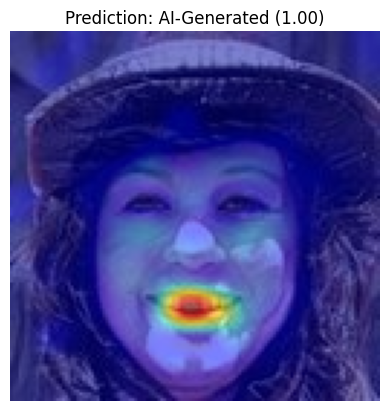

In [ ]:
with torch.no_grad():
    outputs = model(image_tensor)
    probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
    prediction = torch.argmax(probs, dim=-1).item()
    class_labels = ["AI-Generated", "Real"]
    print(f"Prediction: {class_labels[prediction]} with confidence {probs.max().item():.4f}")

visualize_attention(image, attention_maps)

In [ ]:
def evaluate_model_with_plots(model, data_loader, dataset_df, group_cols=["gender", "ethnicity"], plot_title=''):
    model.eval()
    all_labels = []
    all_probs = []
    all_preds = []

    with torch.no_grad():
        for images, labels in tqdm(data_loader, desc="Evaluating"):
            images, labels = images.to("cuda"), labels.to("cuda")
            outputs = model(images).logits
            probs = torch.sigmoid(outputs)

            # Store probabilities for class 1 (Real)
            probs_real = probs[:, 1].detach().cpu().numpy()

            preds = (probs_real >= 0.5).astype(int)  # Threshold at 0.5
            labels = labels.cpu().numpy()

            all_labels.extend(labels)
            all_probs.extend(probs_real)
            all_preds.extend(preds)

    # ---------------------- Metrics Calculation ----------------------
    acc = accuracy_score(all_labels, all_preds)
    auc = roc_auc_score(all_labels, all_probs)
    f1 = f1_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)

    print(f"\n Overall Metrics:")
    print(f"Accuracy: {acc:.4f}, AUC: {auc:.4f}, F1: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")

    # ---------------------- ROC Curve ----------------------
    fpr, tpr, _ = roc_curve(all_labels, all_probs)
    plt.figure(figsize=(8, 8))
    plt.plot(fpr, tpr, color='darkorange', lw=3, label=f'ROC curve (AUC = {auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')

    plt.xlabel('False Positive Rate', fontsize=17)
    plt.ylabel('True Positive Rate', fontsize=17)
    plt.title('ROC Curve ' + plot_title, fontsize=22, weight='bold')
    plt.legend(loc="lower right", fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.grid(True)
    plt.show()

    # ---------------------- Confusion Matrix ----------------------
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["AI-Generated", "Real"])
    fig, ax = plt.subplots(figsize=(8, 8))
    disp.plot(cmap=plt.cm.Blues, values_format='d', ax=ax, colorbar=False)

    plt.title('Confusion Matrix ' + plot_title, fontsize=22, weight='bold')
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.xlabel('Predicted label', fontsize=17)
    plt.ylabel('True label', fontsize=17)
    plt.show()

    # ---------------------- Group-wise Analysis ----------------------
    print("\n Group-wise performance (gender/ethnicity):")

    # Map back predictions to DataFrame
    dataset_df = dataset_df.reset_index(drop=True).copy()
    dataset_df['true_label'] = all_labels
    dataset_df['predicted_label'] = all_preds
    dataset_df['probability_real'] = all_probs

    # Group by gender/ethnicity
    grouped = dataset_df.groupby(group_cols)
    for group_name, group_df in grouped:
        group_acc = accuracy_score(group_df['true_label'], group_df['predicted_label'])
        try:
            group_auc = roc_auc_score(group_df['true_label'], group_df['probability_real'])
        except ValueError:
            group_auc = float('nan')  # In case only one class present in the group
        print(f"Group {group_name}: Accuracy = {group_acc:.4f}, AUC = {group_auc:.4f}")

    return acc, auc, f1, precision, recall


Evaluating: 100%|██████████| 373/373 [03:01<00:00,  2.05it/s]



 Overall Metrics:
Accuracy: 1.0000, AUC: 1.0000, F1: 1.0000, Precision: 1.0000, Recall: 1.0000


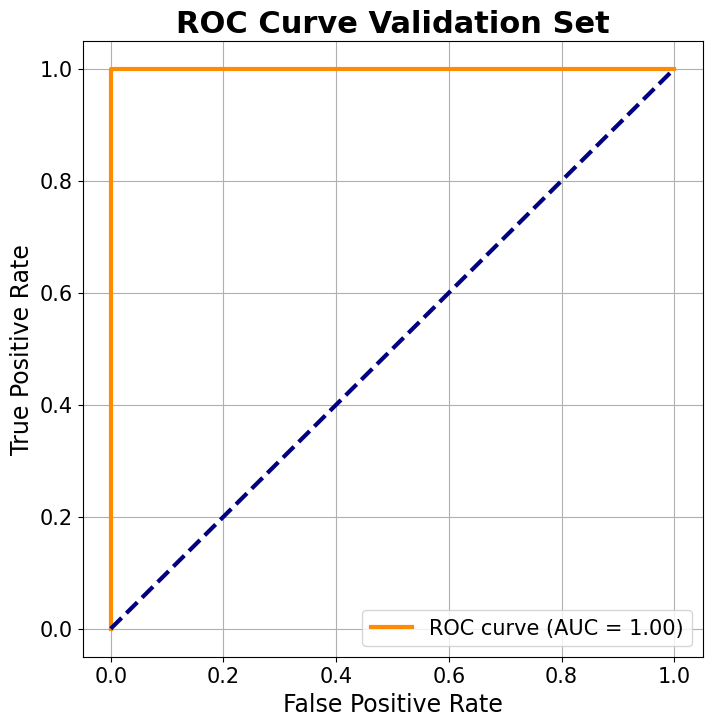

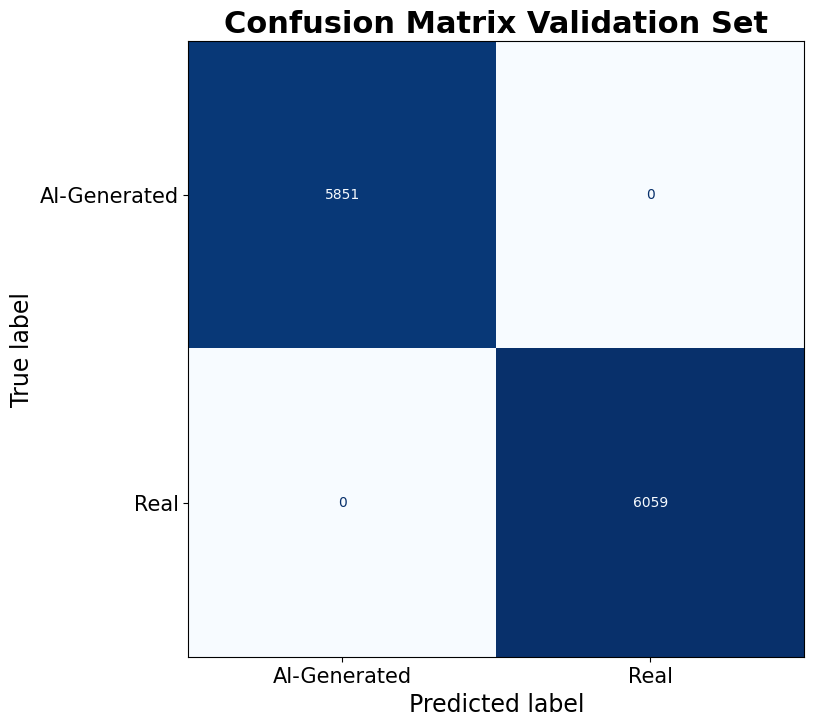


 Group-wise performance (gender/ethnicity):
Group (0, 0): Accuracy = 1.0000, AUC = 1.0000
Group (0, 1): Accuracy = 1.0000, AUC = 1.0000
Group (1, 0): Accuracy = 1.0000, AUC = 1.0000
Group (1, 1): Accuracy = 1.0000, AUC = 1.0000


(1.0, 1.0, 1.0, 1.0, 1.0)

In [ ]:
# Load validation CSV
val_df = pd.read_csv("/content/drive/MyDrive/w210/final_data/val_data.csv")

# Evaluate and plot for validation set
evaluate_model_with_plots(model, val_loader, val_df, group_cols=["gender", "ethnicity"], plot_title='Validation Set')


In [ ]:
import pickle

# Save for later
with open('/content/drive/MyDrive/w210/eval_results.pkl', 'wb') as f:
    pickle.dump({'labels': all_labels, 'probs': all_probs, 'preds': all_preds}, f)

NameError: name 'all_probs' is not defined

In [ ]:
# Load when needed
with open('/content/drive/MyDrive/w210/eval_results.pkl', 'rb') as f:
    data = pickle.load(f)

all_labels = data['labels']
all_probs = data['probs']
all_preds = data['preds']


In [ ]:
from sklearn.metrics import roc_curve, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Assuming you already have these
# all_labels = [...]
# all_probs = [...]
# all_preds = [...]

# ---------------------- ROC Curve ----------------------
fpr, tpr, _ = roc_curve(all_labels, all_probs)
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=3, label=f'ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('ROC Curve', fontsize=16, weight='bold')
plt.legend(loc="lower right", fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)
plt.show()

# ---------------------- Confusion Matrix ----------------------
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["AI-Generated", "Real"])
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(cmap=plt.cm.Blues, values_format='d', ax=ax, colorbar=False)
plt.title('Confusion Matrix', fontsize=16, weight='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Predicted label', fontsize=14)
plt.ylabel('True label', fontsize=14)
plt.show()


NameError: name 'all_probs' is not defined

In [ ]:
# Load test CSV
#test_df = pd.read_csv("/content/drive/MyDrive/w210/final_data/test_data.csv")

# Evaluate and plot for test set
#evaluate_model_with_plots(model, test_loader, test_df, group_cols=["gender", "ethnicity"], plot_title='Test Set')


In [ ]:
model = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224",
    num_labels=2,
    ignore_mismatched_sizes=True
)
model.to("cuda")
model.eval()

print("Pretrained model loaded for pre-fine-tuning evaluation.")

# Prepare validation DataLoader
# val_loader already loaded using RealVsAIDataset

# Prepare corresponding validation DataFrame
val_df = pd.read_csv("/content/drive/MyDrive/w210/final_data/val_data.csv")

# Collect predictions and true labels along with gender and ethnicity
all_preds = []
all_labels = []
all_genders = []
all_ethnicities = []

with torch.no_grad():
    for i, (images, labels) in enumerate(tqdm(val_loader, desc="Evaluating Pre-Fine-Tuning ViT")):
        images = images.to("cuda")
        labels = labels.to("cuda")

        # Model predictions
        outputs = model(images).logits
        probs = torch.nn.functional.softmax(outputs, dim=-1)
        preds = torch.argmax(probs, dim=-1)

        # Store results
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        # Align batch indices with val_df
        batch_indices = range(i * val_loader.batch_size, min((i + 1) * val_loader.batch_size, len(val_df)))
        all_genders.extend(val_df.iloc[batch_indices]['gender'].tolist())
        all_ethnicities.extend(val_df.iloc[batch_indices]['ethnicity'].tolist())

print("Finished collecting predictions for validation set.")

# Convert lists to numpy arrays for analysis
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
all_genders = np.array(all_genders)
all_ethnicities = np.array(all_ethnicities)

# Compute overall and subgroup accuracies

# Overall accuracy
overall_accuracy = (all_preds == all_labels).mean()
print(f"\n Pre Fine-Tuning Overall Accuracy on Validation Set: {overall_accuracy:.4f}")

# Accuracy by gender
print("\n Accuracy by Gender:")
for gender_value in np.unique(all_genders):
    mask = (all_genders == gender_value)
    acc = (all_preds[mask] == all_labels[mask]).mean()
    print(f"Gender {gender_value}: {acc:.4f}")

# Accuracy by ethnicity
print("\n Accuracy by Ethnicity:")
for ethnicity_value in np.unique(all_ethnicities):
    mask = (all_ethnicities == ethnicity_value)
    acc = (all_preds[mask] == all_labels[mask]).mean()
    print(f"Ethnicity {ethnicity_value}: {acc:.4f}")

# Combined gender and ethnicity
print("\n Combined Gender & Ethnicity Accuracy:")
unique_combinations = set(zip(all_genders, all_ethnicities))
for gender_val, eth_val in unique_combinations:
    mask = (all_genders == gender_val) & (all_ethnicities == eth_val)
    acc = (all_preds[mask] == all_labels[mask]).mean()
    print(f"Gender {gender_val} & Ethnicity {eth_val}: {acc:.4f}")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Pretrained model loaded for pre-fine-tuning evaluation.


Evaluating Pre-Fine-Tuning ViT: 100%|██████████| 373/373 [03:03<00:00,  2.03it/s]

Finished collecting predictions for validation set.

 Pre Fine-Tuning Overall Accuracy on Validation Set: 0.4912

 Accuracy by Gender:
Gender 0: 0.4651
Gender 1: 0.5148

 Accuracy by Ethnicity:
Ethnicity 0: 0.5031
Ethnicity 1: 0.4793

 Combined Gender & Ethnicity Accuracy:
Gender 0 & Ethnicity 1: 0.4518
Gender 1 & Ethnicity 0: 0.5172
Gender 1 & Ethnicity 1: 0.5117
Gender 0 & Ethnicity 0: 0.4827


In [ ]:
# checking if there are other reasons that model learned so well which image is real and which is AI generated


image_dir = '/content/drive/MyDrive/w210/final_data/all_images'

# Loop and collect image properties
image_data = []

for idx, row in tqdm(full_df.iterrows(), total=len(full_df)):
    try:
        img_path = os.path.join(image_dir, row['image_filename'])  # Full path
        img = Image.open(img_path)
        width, height = img.size
        image_data.append({
            'width': width,
            'height': height,
            'aspect_ratio': width / height,
            'label': row['label']
        })
    except Exception as e:
        print(f"Error with image {row['image_filename']}: {e}")

# Convert to DataFrame
image_info_df = pd.DataFrame(image_data)
print(image_info_df.head())


  0%|          | 0/79400 [00:00<?, ?it/s]


KeyError: 'image_filename'

In [ ]:
# Check file extensions
full_df['image_filename'].apply(lambda x: x.split('.')[-1]).value_counts()

# Check file size (bytes)
full_df['file_size'] = full_df['image_filename'].apply(os.path.getsize)
print(full_df.groupby('label')['file_size'].describe())


In [ ]:

def plot_color_histogram(image_paths, title):
    r_hist, g_hist, b_hist = np.zeros(256), np.zeros(256), np.zeros(256)

    for img_path in image_paths:
        img = Image.open(img_path).convert("RGB")
        r, g, b = img.split()
        r_hist += np.histogram(np.array(r).flatten(), bins=256, range=(0, 255))[0]
        g_hist += np.histogram(np.array(g).flatten(), bins=256, range=(0, 255))[0]
        b_hist += np.histogram(np.array(b).flatten(), bins=256, range=(0, 255))[0]

    plt.figure(figsize=(12, 4))
    plt.plot(r_hist, color='red', label='Red')
    plt.plot(g_hist, color='green', label='Green')
    plt.plot(b_hist, color='blue', label='Blue')
    plt.legend()
    plt.title(title)
    plt.show()

# Example usage:
real_paths = full_df[full_df['label'] == 1]['image_filename'].sample(100).tolist()
ai_paths = full_df[full_df['label'] == 0]['image_filename'].sample(100).tolist()

plot_color_histogram(real_paths, "Real Image RGB Histograms")
plot_color_histogram(ai_paths, "AI-Generated Image RGB Histograms")


In [ ]:
train_paths = set(train_df['image_filename'].apply(os.path.basename))
test_paths = set(test_df['image_filename'].apply(os.path.basename))

overlaps = train_paths.intersection(test_paths)
print("Number of overlapping files:", len(overlaps))


In [ ]:
import random

def show_sample_images(paths, title):
    sample_paths = random.sample(paths, 5)
    plt.figure(figsize=(15, 5))
    for idx, img_path in enumerate(sample_paths):
        img = Image.open(img_path)
        plt.subplot(1, 5, idx + 1)
        plt.imshow(img)
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

# Example
show_sample_images(real_paths, "Sample Real Images")
show_sample_images(ai_paths, "Sample AI-Generated Images")
